# PY52007 - Guest lecture on Bayesian Inference - Part I
## Dr Benjamin T. Vincent

This session is aimed at students who have some familiarity with frequentist hypothesis testing methods. We do not assume any prior knowledge of Bayesian inference. Although briefly recapping what we covered in PY51001 on Bayesian inference may be useful.

# Goals

This session will be in 2 parts. In Part I we will cover some of the background theory of Bayesian inference. More specifically we will:
- Review the core conceptual ideas and differences between the Bayesian and the Frequentist approaches.
- Work through a concrete example, in code, of Bayesian linear regression.
- Introduce the concepts of a _posterior distribution_ to summarise what you belief after having observed data, and of a _Bayes Factor_ which allows you to do hypothesis testing in a Bayesian manner. 
- Briefly highlight that there is still a debate about the relative merits of summarising findings with posterior distributions versus Bayes Factors.

Part II will be dealt with seperately, but this will focus on practically running Bayesian analyses using the free software, [JASP](https://jasp-stats.org/jasp-materials/).

I do _not_ expect you to fully grasp everything in Part I immediately. It may take 2 or 3 readings of this to fully understand. Nevertheless, you should be able to get a good understanding of the key steps involved in Bayesian inference. You will be able to see that it is no magic and that there are a certain number of specific steps that are taken.

In [15]:
#  Code below is just setup stuff, it is of no meanigful consequence...

# Install Black autoformatter with: pip install nb-black
%load_ext lab_black

%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd

%config InlineBackend.figure_format = 'retina'

SEED = 1234
np.random.seed(SEED)

plt.rcParams.update({"font.size": 14})

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# load my own custom plotting functions
from plots import figure_data_parameter_space, plot_posterior_m, plot_m_bayes_factor

## Use this command to convert into a html slideshow

    jupyter nbconvert Bayesian_Inference.ipynb --to slides

# PART 1


![](img/fig1.PNG)

![](img/fig2.PNG)

![](img/fig3.PNG)

![](img/fig4.PNG)

![](img/fig5.PNG)

## A worked example - Bayesian linear regression

In this section we are going to go through all the steps needed to conduct a simple linear regression using Bayesian methods. The equation for a simple (one predictor variable) linear regression is:
$$ y = mx + c $$

Although there is often observation noise, so we can update this to
$$ y = mx + c  + \epsilon\\
\epsilon \sim \mathrm{Normal}(0, \sigma)$$

In a Bayesian context this is written slightly differently as,
$$
y \sim \mathrm{Normal}(mx + c, \sigma)
$$

We will proceed in a few steps:

1. We will "simulate the world" in order to create some fake data. Because we want to see how well our Bayesian inference does against the truth that we know. If we did this on a real dataset then we don't know what the true relationships are and would not be able to judge our inferences against it. To keep our example simple, we will just have one independent (predictor) variable, $x$.
2. Now we will define our prior beliefs. This is a unique step to the Bayesian approach.
3. Do Bayesian inference by calculating how much we belief in parameter values after having observed the data. Another way of saying this is that we are assessing the credibility for many different parameters given our data. In maths, this can be written as $P(parameters|data)$ which in our specific case is $P(m, c | x, y)$.

First, for the sake of simplicity, we will assume we know the observation noise, $\sigma$.

In [3]:
σ = 0.2

### Simulate some data

In [4]:
def generate_data(m, c, N=10):
    # uniformly random x data
    x = np.random.rand(N)
    # linear regression
    μ = m * x + c
    # normally distributed observation noise
    y = np.random.normal(μ, σ)
    return (x, y)


true_m = 0.5
true_c = 0

x, y = generate_data(true_m, true_c)

Now we are going to plot this simulated data, along with the true regression model. We will also plot the true known parameters.

In [16]:
# Export data for optional analysis in JASP
df = pd.DataFrame({"x": x, "y": y})
df.to_csv("mydata.csv", index=False)

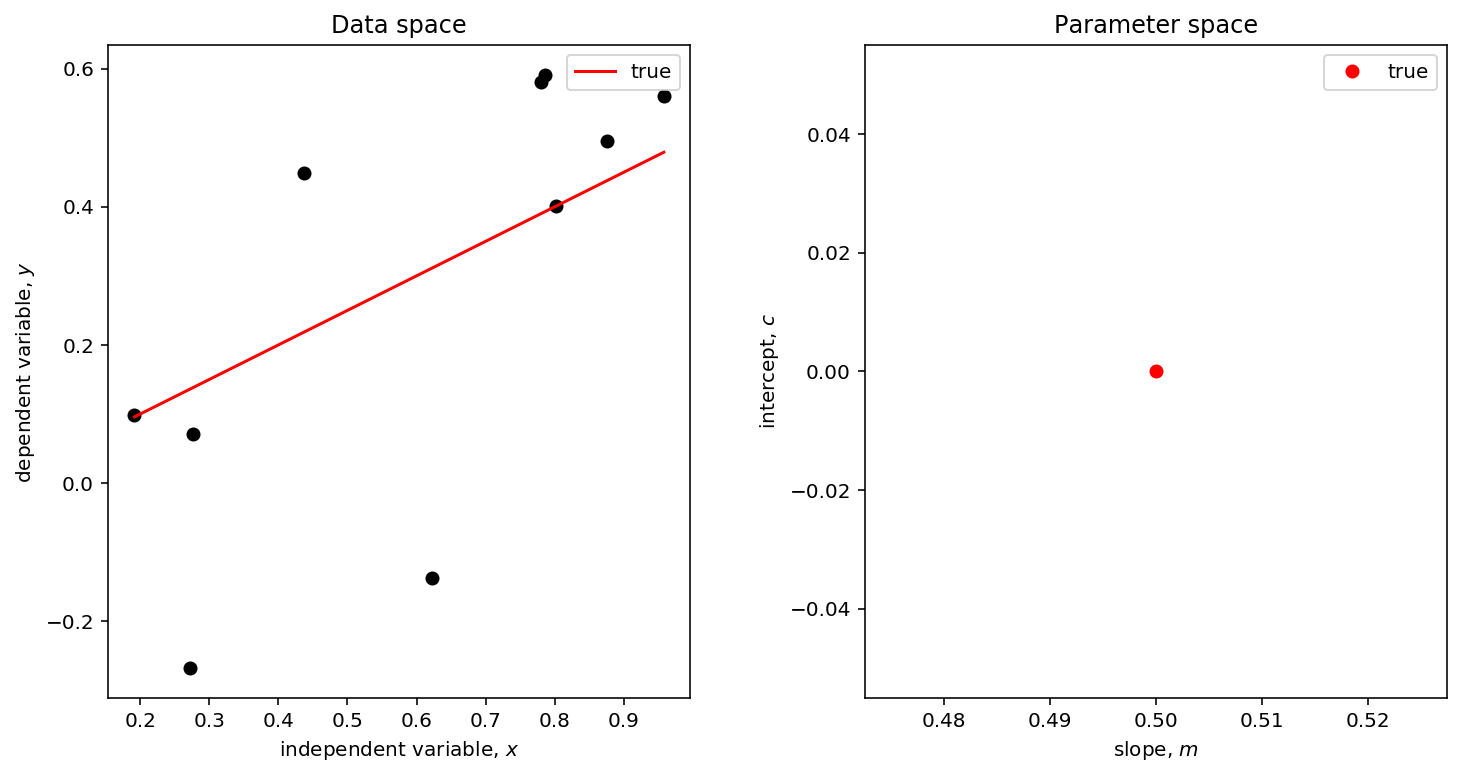

In [5]:
figure_data_parameter_space(x, y, true_m, true_c)

### Express our prior knowledge

In [6]:
m_prior = norm(0, 1)
c_prior = norm(0, 1)

We can view our prior beliefs in data space (left). That is, we can see what kind of regression lines we get acording to our prior beliefs.

We can also view our prior beliefs in the form of a heatmap in parameter space (right).

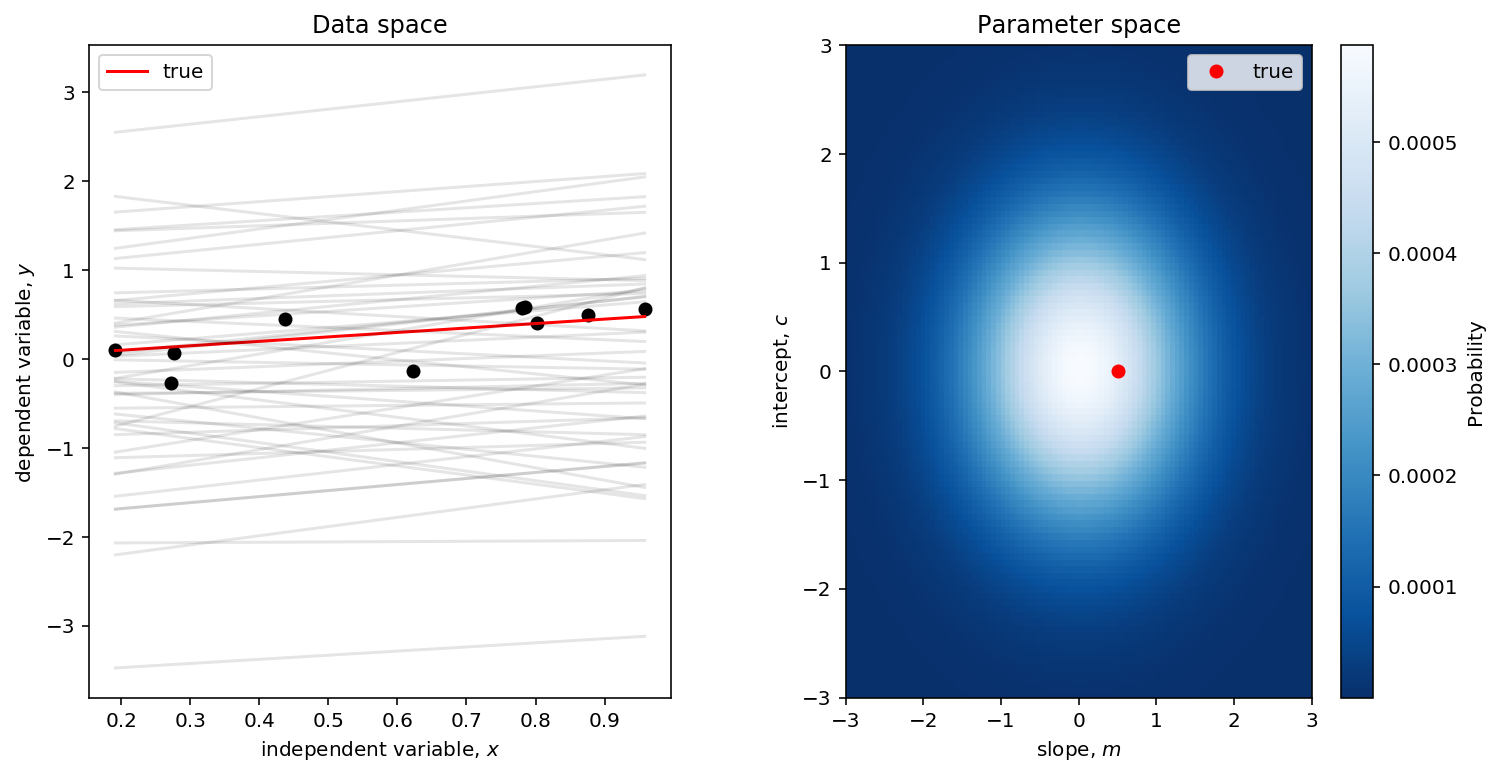

In [7]:
figure_data_parameter_space(
    x, y, true_m=true_m, true_c=true_c, m_prior=m_prior, c_prior=c_prior
)

plt.savefig("img/prior.png", bbox_inches="tight", dpi=144)

What we have now is a visualisation of our data (points), as well as the true relationshion between $x$ and $y$ (in red).

We also have a visualisation of our prior beliefs. Firstly in the colormap (right) where brighter colours represent higher prior probability. Secondly by sample regression lines which are randomly sampled from our prior beliefs.

### Bayesian inference
So far we have _not_ done any Bayesian inference. What we have done is to generate our data and speficy our priors. The next step is to do some Bayesian inference.

Baye's equation can be written generally as:
$$
P(params|data) \propto P(data|params) \cdot P(params)
$$

where the prior is

$$
P(params) = P(m, c) = \mathrm{Normal}(m; 0, 1) \cdot \mathrm{Normal}(c; 0, 1)
$$

and the likelihood is 

$$
P(data|params) = P(x, y|m,c) = \prod_{i=1}^N \mathrm{Normal}(y; m \cdot x_i + c, \sigma)
$$

This can be calculated in the function below:

In [8]:
def posterior(parameters, data):
    """Return the Bayesian posterior probability P(parameters|data)"""
    m, c = parameters
    x, y = data
    prior = m_prior.pdf(m) * c_prior.pdf(c)
    likelihood = np.prod(norm.pdf(y, loc=m * x + c, scale=σ))
    posterior = likelihood * prior
    return posterior

In [9]:
# define range to look at
mi = np.linspace(-3, 3, 160)
ci = np.linspace(-1, 1, 160)

# initialise empty array
post = np.zeros([len(ci), len(mi)])

In [10]:
# loop over (m, c) values, calculating the posterior
for ind_m, m in enumerate(mi):
    for ind_c, c in enumerate(ci):
        post[ind_c, ind_m] = posterior(parameters=(m, c), data=(x, y))

# normalise to sum to 1
post = post / np.sum(post)

Visualise

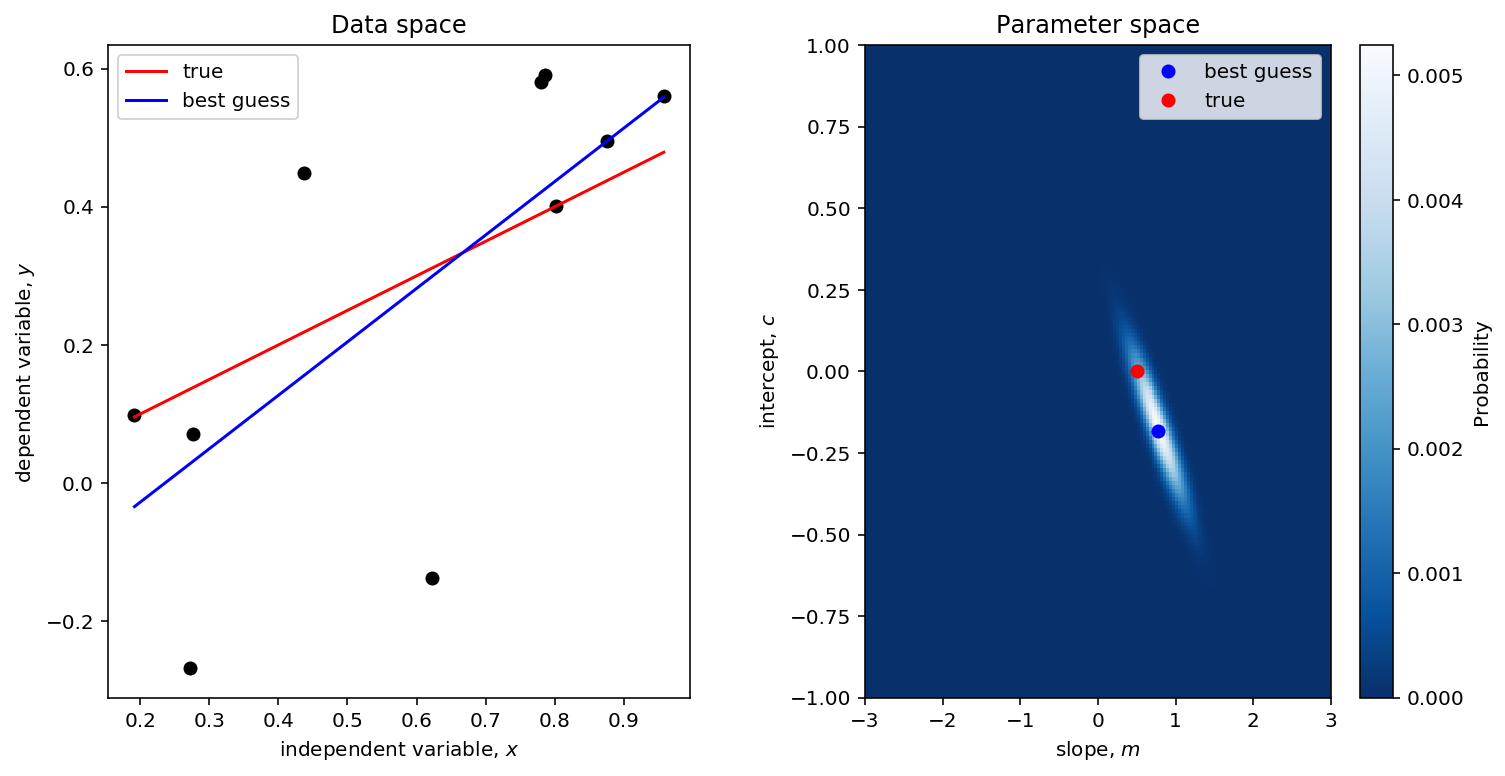

In [11]:
figure_data_parameter_space(
    x,
    y,
    true_m=true_m,
    true_c=true_c,
    m_prior=m_prior,
    c_prior=c_prior,
    posterior=(mi, ci, post),
)

plt.savefig("img/posterior.png", bbox_inches="tight", dpi=144)

In [12]:
# calculate (m, c) values at the posterior mode
ind = np.unravel_index(np.argmax(post, axis=None), post.shape)
m_best_guess, c_best_guess = mi[ind[1]], ci[ind[0]]

print(f"True (m,c) = ({true_m},{true_c})")
print(f"Best guess (m,c) = ({m_best_guess},{c_best_guess})")

True (m,c) = (0.5,0)
Best guess (m,c) = (0.7735849056603774,-0.1823899371069182)


### Posterior distributions
The plot above shows the 2D posterior distribution of belief over the parameters $(m, c)$. That is, we can view the credibility for many different parameter combinations, and some are more credible in the light of the data than others.

We can also take 'slices' and look at the credibility of just $m$ or just $c$. For puposes of demonstration, let's say that we are particularly interested in just the slope, $m$, for the moment.

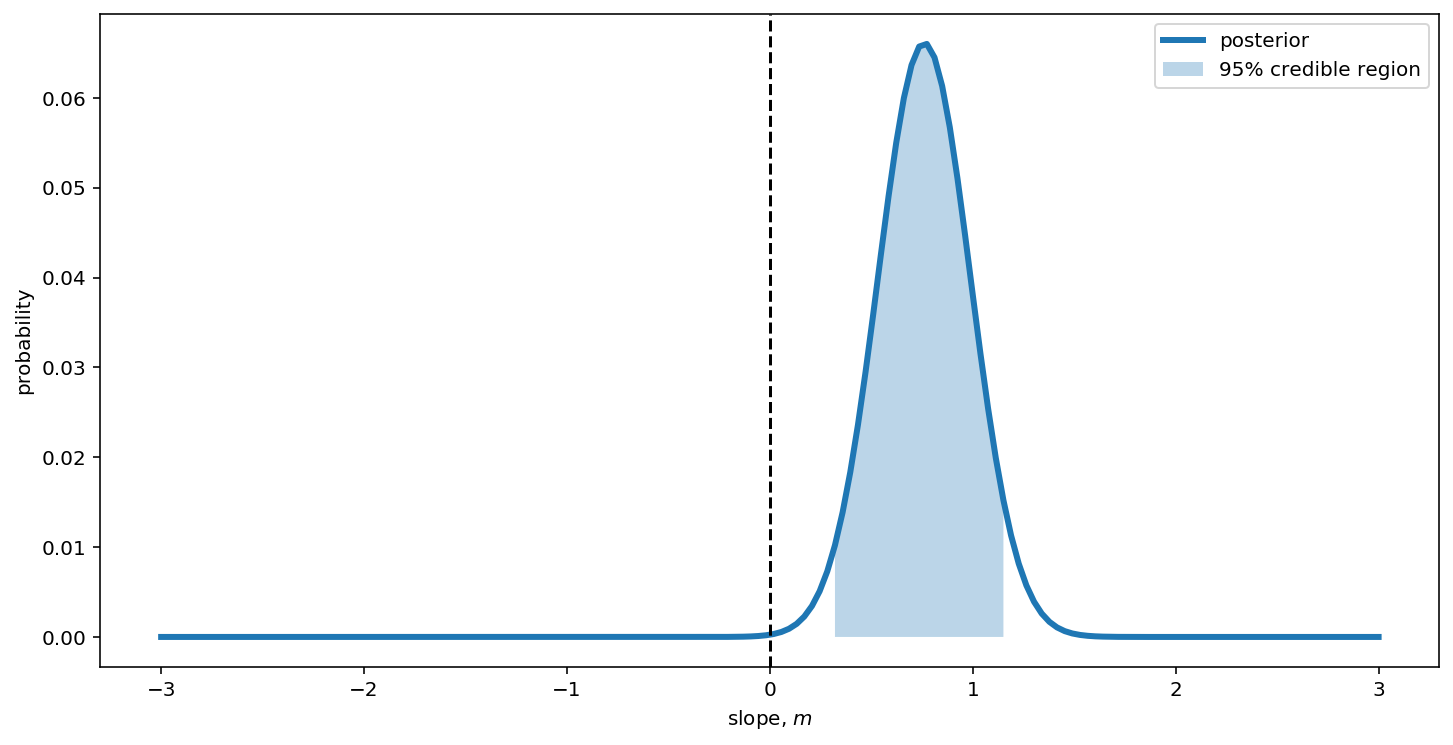

In [13]:
plot_posterior_m(post, mi)

You can look at the 95% credible region of the posterior and see if it overlaps with zero.

- If not, then you could state that zero falls outside of the 95% credible region and so you are very convinced that there is an effect.
- If so, then you could state there is _not_ credible evidence to believe the parameter is different from zero.

A _Bayesian credible interval_ is NOT the same thing as a frequentist _confidence interval_.
![](img/credible_confidence.png)

_From a talk by Jake VanderPlas_

### Bayes Factors (i.e. hypothesis testing in a Bayesian approach)
An alternative approach is to calculate a [Bayes Factor](https://en.wikipedia.org/wiki/Bayes_factor). To do this you calculate the ratio of probabilities in some values (i.e. $m=0$) under the prior and the posterior. That is, you see how many times the credibility has gone up or down.

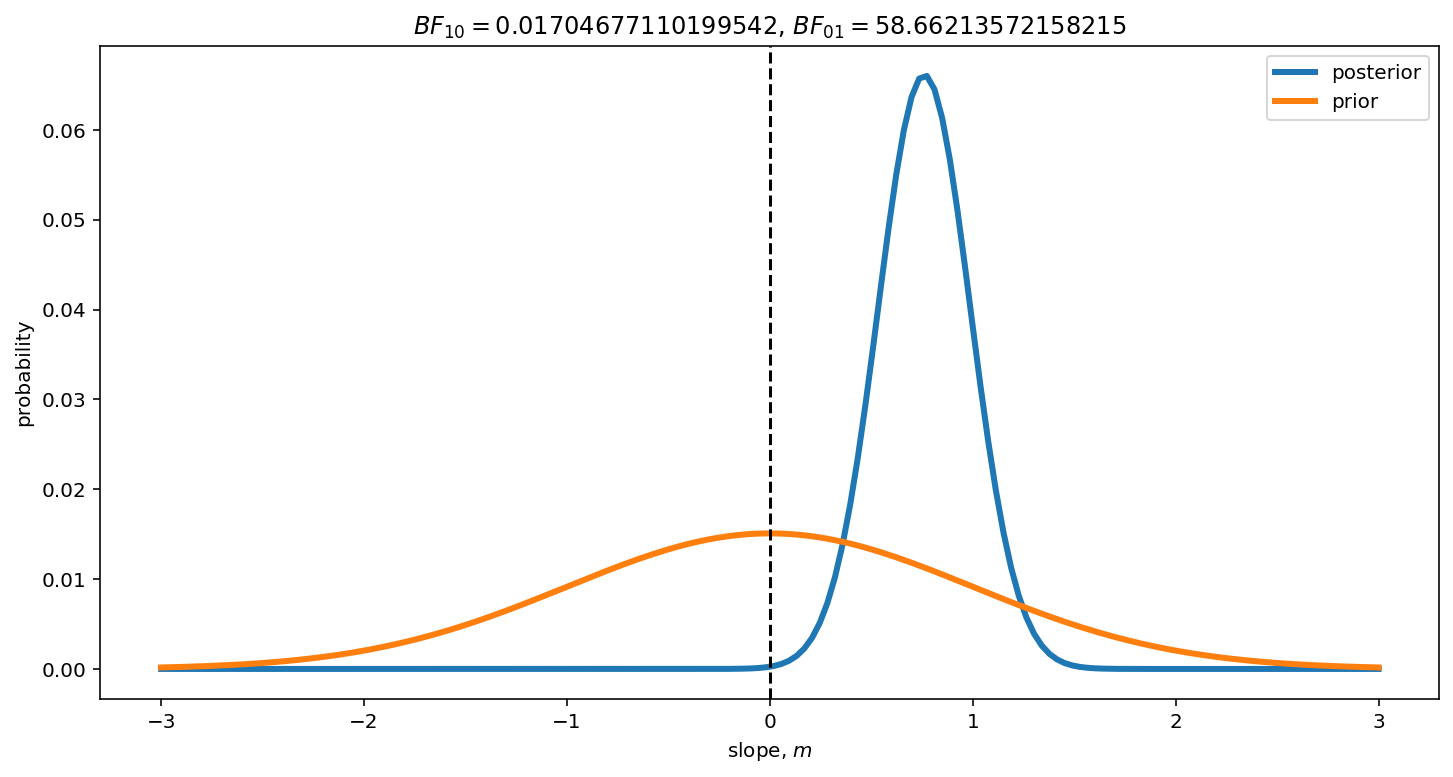

In [14]:
plot_m_bayes_factor(mi, post, m_prior)

You can then make a judgement on whether this ratio (change in credibility) is high or low or somewhere in between. One way to do this is to consult the table below (adapted from Wagenmakers, et al, 2011):
![](img/bftable.png)

(see http://daniellakens.blogspot.com/2016/01/power-analysis-for-default-bayesian-t.html)

## Posterior distribution versus Bayes Factor debate

Kruschke, J. K., & Liddell, T. M. (2018). The Bayesian new statistics: two historical trends converge. Psychonomic Bulletin & Review, 25, 178–205.

Kruschke, J. K. (2011). Bayesian Assessment of Null Values Via Parameter Estimation and Model Comparison. Perspectives on Psychological Science, 6(3), 299–312. http://doi.org/10.1177/1745691611406925

Wagenmakers, E.-J., Verhagen, J., Ly, A., Matzke, D., Steringoever, H., Rouder, J. N., & Morey, R. D. (2015). The Need for Bayesian Hypothesis Testing in Psychological Science, 1–29.

# Resources

## Papers

- Wagenmakers, E.-J., Wetzels, R., Borsboom, D., & van der Maas, H. L. J. (2011). Why psychologists must change the way they analyze their data: The case of psi: Comment on Bem (2011). Journal of Personality and Social Psychology, 100(3), 426–432. https://doi.org/10.1037/a0022790 
- Wagenmakers, E.-J., Love, J., Marsman, M., Jamil, T., Ly, A., Verhagen, J., et al. (2018). Bayesian inference for psychology. Part II: Example applications with JASP. Psychonomic Bulletin & Review, 25(1), 1–19. http://doi.org/10.3758/s13423-017-1323-7
- Kruschke, J. K., & Liddell, T. M. (2017). Bayesian data analysis for newcomers. Psychonomic Bulletin & Review, 17(3), 251–23. http://doi.org/10.3758/s13423-017-1272-1

## Textbooks
- Dienes, Z. (2008). Understanding Psychology as a Science: An Introduction to Scientific and Statistical Inference. Palgrave Macmillan.
- Kruschke, J. K. (2015). Doing Bayesian Data Analysis: A Tutorial with R, JAGS, and Stan (2nd ed.). Academic Press.
- McElreath, R. (2016). Statistical Rethinking: A Bayesian Course with Examples in R and Stan. CRC Press.

## Videos
- An entire lecture series on Bayesian inference by Richard McElreath https://www.youtube.com/watch?v=4WVelCswXo4&list=PLDcUM9US4XdNM4Edgs7weiyIguLSToZRI

## Blogs
- http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/ (Part 1 of 5)